## Prerequisite Packages

In [227]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec


## We split the data into training and testing

In [50]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [51]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [52]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()
# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32   
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()  #store and memtory >> Need to use cache if we don't want to get error
ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)  #shuffle
ds_val = ds_val.batch(32)# batch of 32    
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE) #Need to use prefetch if we don't want to get error 

#cache & prefetch: store dataset into memory, so can quickly train the model

ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


## Model training

In [53]:

# this example model 
#    - first flattens data into a vector (image is 28 x 28)
#    - then creates a dense 128-node layer
#    - then creates a dropout "layer" (it says how many nodes are dropped out in previous layer)
#    - then another 128-node layer
#    - and finally 10-node layer as the head. 
# The max value of the head = the predicted image
#
from keras import backend as K


dense=False
if dense:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(56,activation='relu'),
    tf.keras.layers.Dropout(.2, input_shape=(56,)),
      tf.keras.layers.Dense(24,activation='relu'),
      tf.keras.layers.Dense(10)
    ])
else:
    model = tf.keras.models.Sequential([])
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1))) 
    #kernal_size = 3: how many filter/weight we use, 'relu': BEST image activation
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.5))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.BatchNormalization())
    #tf.keras.layers.Dense(24,activation='relu'),
    model.add(tf.keras.layers.Dense(10))  #0,1,2,3,4,5,6,7,8,9
# this specifies how we find the best NN
# - Optimizer like Adam is found to work well
# - Loss is "sparse categorical cross entropy" (you can choose whatever loss function on keras improves your model)
# - We also record accuracy ("metric"), this does not affect training
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is stuff we record
# "early stopping" tells us when we found the optimum without training more epochs
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# the training of the model
# we use ds_train data, and up to 30 epochs (less when Early Stopping is used)
# we also record callbacks, and we determine the optimal model by where validation is smallest
history=model.fit(
    ds_train,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=ds_val
)


Epoch 1/30
1500/1500 [==============================] - 105s 68ms/step - loss: 0.3161 - sparse_categorical_accuracy: 0.9018 - val_loss: 0.0715 - val_sparse_categorical_accuracy: 0.9787
Epoch 2/30
1500/1500 [==============================] - 104s 69ms/step - loss: 0.0718 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.0561 - val_sparse_categorical_accuracy: 0.9822
Epoch 3/30
1500/1500 [==============================] - 103s 69ms/step - loss: 0.0489 - sparse_categorical_accuracy: 0.9842 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9843
Epoch 4/30
1500/1500 [==============================] - 100s 67ms/step - loss: 0.0385 - sparse_categorical_accuracy: 0.9879 - val_loss: 0.0484 - val_sparse_categorical_accuracy: 0.9852
Epoch 5/30
1500/1500 [==============================] - 102s 68ms/step - loss: 0.0293 - sparse_categorical_accuracy: 0.9902 - val_loss: 0.0460 - val_sparse_categorical_accuracy: 0.9867
Epoch 6/30
1500/1500 [==============================] - 85s 57ms/step - los

In [215]:
50000/32

1562.5

In [225]:
#ds_test = list(ds_test)
#print(ds_test)

dsts = list(ds_test)
testing_data_arr = []
testing_class_arr = []
for i in range(len(dsts)):
    testing_data_arr.append(dsts[i][0])
    testing_class_arr.append(dsts[i][1])


# Layer 1

5
1
1
26
26
64


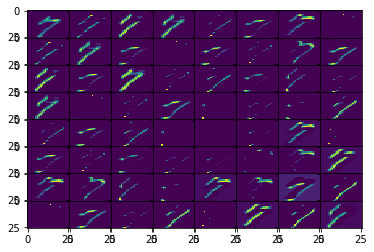

In [305]:
outputs = []
for layer in model.layers:
    keras_function = K.function([model.input], [layer.output])
    outputs.append(keras_function([testing_data_arr[10][10].numpy().reshape(1,28,28,1)]))

print(len(outputs))
print(len(outputs[0]))
print(len(outputs[0][0]))
print(len(outputs[0][0][0]))
print(len(outputs[0][0][0][0]))
print(len(outputs[0][0][0][0][0]))
 
random_int = np.random.randint(0,len(outputs[0][0]))
a = np.array(outputs[0][0][random_int])
image=(a/256)[:,:,i]
  
    
fig, ax = plt.subplots(8, 8, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(8):
    for j in range(8):
        random_int = np.random.randint(0,len(outputs[0][0]))
        a = np.array(outputs[0][0][random_int])
        image=(a/256)[:,:,((i+1)*(j+1))-1]
        ax[i,j].imshow(image, interpolation='nearest', aspect='auto')



# Layer 2

5
1
1
24
24
32


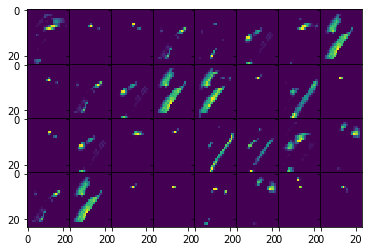

In [306]:
print(len(outputs))
print(len(outputs[1]))
print(len(outputs[1][0]))
print(len(outputs[1][0][0]))
print(len(outputs[1][0][0][0]))
print(len(outputs[1][0][0][0][0]))
    
random_int = np.random.randint(0,len(outputs[1][0]))
a = np.array(outputs[1][0][random_int])
image=(a/256)[:,:,i]   
    
fig, ax = plt.subplots(4, 8, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(4):
    for j in range(8):
        random_int = np.random.randint(0,len(outputs[1][0]))
        a = np.array(outputs[1][0][random_int])
        image=(a/256)[:,:,((i+1)*(j+1))-1]
        ax[i,j].imshow(image, interpolation='nearest', aspect='auto')

# Layer 3

5
1
1
24
24
32


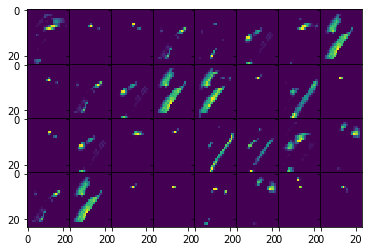

In [307]:
print(len(outputs))
print(len(outputs[2]))
print(len(outputs[2][0]))
print(len(outputs[2][0][0]))
print(len(outputs[2][0][0][0]))
print(len(outputs[2][0][0][0][0]))
   
random_int = np.random.randint(0,len(outputs[2][0]))
a = np.array(outputs[2][0][random_int])
image=(a/256)[:,:,i] 
    
fig, ax = plt.subplots(4, 8, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(4):
    for j in range(8):
        random_int = np.random.randint(0,len(outputs[2][0]))
        a = np.array(outputs[2][0][random_int])
        image=(a/256)[:,:,((i+1)*(j+1))-1]
        ax[i,j].imshow(image, interpolation='nearest', aspect='auto')

# Layer 4

In [308]:
print(len(outputs))
print(len(outputs[3]))
print(len(outputs[3][0]))
print(len(outputs[3][0][0]))
print(len(outputs[3][0][0][0]))
print(len(outputs[3][0][0][0][0]))

random_int = np.random.randint(0,len(outputs[3][0]))
a = np.array(outputs[3][0][random_int])
image=(a/256)[:,:,i]
    
fig, ax = plt.subplots(4, 8, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(4):
    for j in range(8):
        random_int = np.random.randint(0,len(outputs[3][0]))
        a = np.array(outputs[3][0][random_int])
        image=(a/256)[:,:,((i+1)*(j+1))-1]
        ax[i,j].imshow(image, interpolation='nearest', aspect='auto')

5
1
1
18432


TypeError: object of type 'numpy.float32' has no len()

# Layer 5

In [309]:
print(len(outputs))
print(len(outputs[4]))
print(len(outputs[4][0]))
print(len(outputs[4][0][0]))
print(len(outputs[4][0][0][0]))
print(len(outputs[4][0][0][0][0]))
  
random_int = np.random.randint(0,len(outputs[4][0]))
a = np.array(outputs[4][0][random_int])
image=(a/256)[:,:,i]
    
fig, ax = plt.subplots(4, 8, sharex='col', sharey='row')
fig.subplots_adjust(hspace=0, wspace=0)
for i in range(4):
    for j in range(8):
        random_int = np.random.randint(0,len(outputs[4][0]))
        a = np.array(outputs[4][0][random_int])
        image=(a/256)[:,:,((i+1)*(j+1))-1]
        ax[i,j].imshow(image, interpolation='nearest', aspect='auto')

5
1
1
10


TypeError: object of type 'numpy.float32' has no len()

In [29]:
from keras import backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]  # all layer outputs
print(outputs)
#functor = K.function([inp, K.learning_phase()], outputs )   # evaluation function

# Testing
#test = np.random.random(input_shape)[np.newaxis,...]
#layer_outs = functor([test, 1.])
#print (layer_outs)


[<KerasTensor: shape=(None, 26, 26, 64) dtype=float32 (created by layer 'conv2d')>, <KerasTensor: shape=(None, 24, 24, 32) dtype=float32 (created by layer 'conv2d_1')>, <KerasTensor: shape=(None, 24, 24, 32) dtype=float32 (created by layer 'dropout')>, <KerasTensor: shape=(None, 18432) dtype=float32 (created by layer 'flatten')>, <KerasTensor: shape=(None, 10) dtype=float32 (created by layer 'dense')>]


## Here we check the accuracy in the held-out test dataset

In [216]:

gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
accuracy_score(predictions,gt_labels)

ValueError: Data cardinality is ambiguous:
  x sizes: 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16, 16
Make sure all arrays contain the same number of samples.

## How does loss in training/validation vary with epoch?

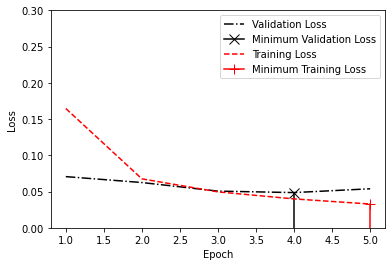

In [17]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()
